# Text Classification with Neural Networks

The goal of this project is to develop a **classification model to predict the positive/negative labels** of movie reviews.

We'll be using the **large movie review dataset**, https://ai.stanford.edu/~amaas/data/sentiment/, compiled by Maas et al. (https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf). This dataset can be loaded directly via the Keras imdb.load_data() method.

To accomplish our goal, we'll develop artificial neural network models with different architectures, such as:

1. **Dense** classifier
* **Convolutional** classifier
* **RNN (simple RNN layer)** classifier
* **RNN (GRU layer)** classifier
* **RNN (LSTM layer)** classifier
* **RNN (bidirectional LSTM layer)** classifier
* **Stacked RNN (2 bidirectional LSTM layers)** classifier
* **Convolutional layer + bidirectional LSTM layer** classifier
* **Multi-convolutional** classifier

We'll start by developing a **dense classifier**.

### Step 1

#### 1. Perform initial imports

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint

import os

import numpy as np
import pandas as pd

Using TensorFlow backend.


#### 2. Load data

In [2]:
# values used in Maas et al.:
#"We build a fixed dictionary of the 5,000 most frequent tokens, 
#but ignore the 50 most frequent terms from the original full vocabulary."

n_unique_words = 5000 #number of most frequent words to consider
n_words_to_skip = 50 #number of most frequent words to ignore

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words, 
                                                      skip_top=n_words_to_skip)

#### 3. Check data

In [3]:
#check 3 first reviews of the training data

x_train[0:3]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

Each token is represented by an integer, following this convention:
* **0** is the **padding token**
* **1** is the **starting token**, indicating the beginning of a review
* **2** is the **unknown token**, used to identify the out-of-vocabulary (OOV) words 
* **3** is the **most frequent word** in the corpus
* **4** is the **second most frequent word** in the corpus, and so on

In [4]:
# integer 3 is not used
n_3=0
n_4=0

for index in range(len(x_train)):
    n_3 += x_train[index].count(3)
    n_4 += x_train[index].count(4)

print(n_3, n_4)

0 0


In [5]:
# check length of the 3 first reviews of the training data

for x in x_train[0:3]:
    print(len(x))

218
189
141


As expected, the reviews have different lengths.

In [6]:
# check labels of the 3 first reviews of the training data

y_train[0:3]

array([1, 0, 0], dtype=int64)

The first review is positive and the second and third reviews are negative.

In [7]:
# check length of the training and test set

len(x_train), len(x_test)

(25000, 25000)

We have 25000 reviews in the training set and 25000 reviews in the test set.

#### 4. Check reviews as a sequence of words (and not integers)

Instead of having a sequence of integers for each review, we can also check their original content using Keras imdb.get_word_index() method. 

In [8]:
word_index = imdb.get_word_index()

for key, value in word_index.items():
    if (value == 0) or (value == 1) or (value == 2):
        print(key, value)

the 1
and 2


In [9]:
print(min(word_index, key=word_index.get), word_index[min(word_index, key=word_index.get)])

the 1


As we can see, the first integers are not reserved for the special cases we've mentioned before (and the values start in 1).

In [10]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
#word_index["<UNUSED>"] = 3

In [11]:
# 3 is not used!!!
for key, value in word_index.items():
    if value == 3:
        print(key, value)

In [12]:
# the most common word is "the"
word_index['the']

4

In [13]:
# inverting the word_index dictionary

index_word = {v:k for k,v in word_index.items()}

index_word[4]

'the'

In [14]:
# first review of the training set as a sequence of words

' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

This is the first review of the training set. Since we've excluded some words with the parameters `num_words` and `skip_top` when loading the reviews, those words are identified by the string 'UNK'.

Let's view this first original review.

#### 5. Check original reviews as a sequence of words

In [15]:
(original_x_train,_), (original_x_test,_) = imdb.load_data()

In [16]:
' '.join(index_word[id] for id in original_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### 6. Preprocess data

In [17]:
# make each review the same length using 0 as the padding value

max_review_length = 100 #maximum review length of 100 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

In [18]:
# check length of the 3 first reviews of the training data

for x in x_train[0:3]:
    print(len(x))

100
100
100


All the reviews have now the **same length of 100 words**.

In [19]:
# first review of the training set as a sequence of words after preprocessing

' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

As we can see, this review was truncated in order to keep the last 100 words.

#### 7. Design a dense neural network

In [20]:
# output directory name:
output_dir = 'text_classification_NN/dense'

# training:
epochs = 4
batch_size = 128

n_dim = 64 #number of dimensions of our word-vector space

# neural network architecture: 
n_dense = 64 #number of neurons in dense layer
dropout = 0.5

model = Sequential(name='model_dense')
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [21]:
model.summary()

Model: "model_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


We have designed our model. It's now time to compile it!

#### 8. Compile model and create callback to save model parameters

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Our model is now compiled. We've used `binary_crossentropy` as our loss function since we have a binary classifier.

In [23]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [24]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 9. Train model

In [25]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 4s 168us/step - loss: 0.5495 - accuracy: 0.7032 - val_loss: 0.3486 - val_accuracy: 0.8472
Epoch 2/4
25000/25000 [==============================] - 4s 155us/step - loss: 0.2812 - accuracy: 0.8902 - val_loss: 0.3467 - val_accuracy: 0.8460
Epoch 3/4
25000/25000 [==============================] - 4s 156us/step - loss: 0.1166 - accuracy: 0.9652 - val_loss: 0.4387 - val_accuracy: 0.8317
Epoch 4/4
25000/25000 [==============================] - 4s 156us/step - loss: 0.0232 - accuracy: 0.9963 - val_loss: 0.5471 - val_accuracy: 0.8312


The **highest validation accuracy** is achieved in **epoch 1** and the **lowest validation loss** is achieved in **epoch 2**.

#### 10. Make predictions with the test set

In [26]:
# load parameters of epoch 2

model.load_weights(output_dir+"/weights.02.hdf5")

In [27]:
# in Keras, for this specific case, we can use both predict() and predict_proba() to get the predicted probabilities

predictions = model.predict(x_test)
predictions_proba = model.predict_proba(x_test)

In [28]:
predictions[0:3]

array([[0.1114077],
       [0.9683994],
       [0.8703293]], dtype=float32)

In [29]:
predictions_proba[0:3]

array([[0.1114077],
       [0.9683994],
       [0.8703293]], dtype=float32)

In [30]:
# if we want to get the classes directly, we can use predict_classes()

predictions_class = model.predict_classes(x_test)

In [31]:
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 11. Evaluate model

We can start by comparing the first 10 predictions with the real labels.

In [32]:
predictions_class[0:10].T

array([[0, 1, 1, 0, 1, 1, 1, 0, 1, 1]])

In [33]:
y_test[0:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

For the first 10 reviews, only 1 seems to be misclassified. Let's investigate this further.

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [35]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10724  1776]
 [ 2073 10427]]


In [36]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [37]:
# accuracy score

acc_dense = accuracy_score(y_test, predictions_class)
print(acc_dense)

0.84604


As we've seen before when we trained it, our dense model correctly classifies **84,6%** of our reviews as positive or negative.

Another useful metric to evaluate the performance of our binary classifier is the **area under the curve of the receiver operating characteristic**, or the AUC of the ROC (also known as **ROC AUC**).

The ROC AUC combines two different metrics - **true positive rate (TPR)** and **false positive rate (FPR)**.<br><br>

* $ TPR = \frac{TP}{TP+FN} $
<br><br>
* $ FPR = \frac{FP}{FP+TN} $

Let's plot the ROC curve and calculate the ROC AUC value of our model.

In [38]:
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

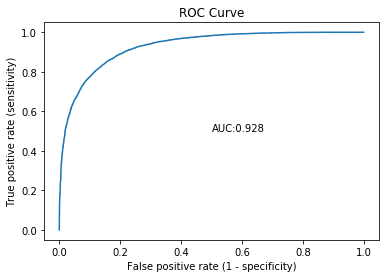

In [39]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_dense = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_dense))
plt.title('ROC Curve');

Our dense model has a **ROC AUC** value of **0.928**. Let's store the accuracy and ROC AUC values for later.

In [71]:
# create a model_scores dictionary to store the accuracy and ROC AUC of each model

model_scores = {'model': [], 'accuracy': [], 'roc_auc': []}

model_scores['model'].append('Dense')
model_scores['accuracy'].append('{:.3f}'.format(acc_dense))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_dense))

In [72]:
model_scores

{'model': ['Dense'], 'accuracy': ['0.846'], 'roc_auc': ['0.928']}

We can also have a look into some of the reviews that were incorrectly classified to have a sense of what's going on. In order to do that, let's create a dataframe with the predicted values for each review and the corresponding original label.

In [42]:
pred_values = []

for prediction in predictions:
    pred_values.append(prediction[0])

In [43]:
df = pd.DataFrame(list(zip(pred_values, y_test)), columns=['y_pred', 'y'])

In [44]:
df.head()

y_pred  y
0  0.111408  0
1  0.968399  1
2  0.870329  1
3  0.314741  0
4  0.991241  1

Let's focus on the more extreme cases, i. e., misclassified reviews with predicted probabilities of being positive higher than 0.9 or lower than 0.1.

In [45]:
# negative reviews incorrectly classified with predicted probability of being positive > 0.9

df[(df.y == 0) & (df.y_pred > 0.9)].head(10)

y_pred  y
112  0.912652  0
256  0.917231  0
302  0.932703  0
386  0.908056  0
547  0.939021  0
555  0.916817  0
680  0.937109  0
693  0.955089  0
740  0.971992  0
778  0.928151  0

In [49]:
# check original review with index 112

neg_review = ' '.join(index_word[id] for id in original_x_test[112])

' '.join(neg_review.split()[-100:]) # our model only considers the last 100 words

'and quite possibly they will wind up like a little lamb to the slaughter house plenty of blood gore nudity handcuffs and all kinds of blood draining hooks and things you will never dream a person is capable of performing on men and women if you like piercing well this kind of piercing deals with heavy heavy hooks and plenty of besides lots of needles and thread to seal up things on the human body i really hope that this film does not give some sick person in this world the idea to act out these horrors in real life'

In [50]:
# positive reviews incorrectly classified with predicted probability of being positive < 0.1

df[(df.y == 1) & (df.y_pred < 0.1)].head(10)

y_pred  y
101  0.033927  1
231  0.087867  1
242  0.099000  1
300  0.048005  1
322  0.059851  1
325  0.090182  1
333  0.029505  1
345  0.043246  1
663  0.075248  1
667  0.031759  1

In [51]:
# check original review with index 101

pos_review = ' '.join(index_word[id] for id in original_x_test[101])

' '.join(pos_review.split()[-100:]) # our model only considers the last 100 words

"movie is pretty damn good br br one thing that must be said it deals with the highschool students' life in turkey very realistically that's exactly how it goes the scenes that are meant to scare are somewhat cheap and hollywoodish most of them even if not all but that religion lesson scene made me laugh in tears and performs the best acting of this flick as a religion teacher br br it's not a waste of your time go and watch it you'll find it rather amusing especially if you know turkey enough to relate to turkish school lives"

It's not easy to determine why our model was not able to correctly classify these examples, but it can be useful to have the possibility of doing this kind of ad hoc analysis.

In **step 2** we will now develop a **convolutional classifier**.

### Step 2

#### 1. Perform necessary imports

In [52]:
from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D

#### 2. Load data

In [53]:
# considering the 5000 most frequent words as in our first step
# and removing the skip_top parameter

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [54]:
max_review_length = 400 #maximum review length of 400 words
pad_type = 'pre' #add padding characters to the start of every review < 400 words
trunc_type = 'pre' #remove words from the beginning of every review > 400 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

#### 4. Design a convolutional neural network

In [55]:
# output directory name:
output_dir = 'text_classification_NN/cnn'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# convolutional layer architecture:
n_conv = 256 #number of filters/kernels
k_conv = 3 #kernel length

# dense layer architecture: 
n_dense = 256 #number of neurons
dropout = 0.2

model = Sequential(name='model_cnn')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [56]:
model.summary()

Model: "model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25

Our CNN model is now ready to be compiled and trained.

#### 5. Compile model and create callback to save model parameters

In [57]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [59]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Train model

In [64]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 76s 3ms/step - loss: 0.4973 - accuracy: 0.7331 - val_loss: 0.3134 - val_accuracy: 0.8666
Epoch 2/4
25000/25000 [==============================] - 73s 3ms/step - loss: 0.2485 - accuracy: 0.9002 - val_loss: 0.2744 - val_accuracy: 0.8845
Epoch 3/4
25000/25000 [==============================] - 72s 3ms/step - loss: 0.1701 - accuracy: 0.9360 - val_loss: 0.2703 - val_accuracy: 0.8907
Epoch 4/4
25000/25000 [==============================] - 74s 3ms/step - loss: 0.1151 - accuracy: 0.9596 - val_loss: 0.3025 - val_accuracy: 0.8868


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 3**.

#### 7. Make predictions with the test set

Instead of loading only the model weigths, we can also load the entire model (model weights, model architecture, compilation details and optimizer state - since we're using the Adam optimizer we have an adaptive learning rate, i.e., the learning rate changes with time).

This is can be very useful if, for example, we need to make a break and restart our kernel. In order to do this, we can use the Keras `load_model()` function. If we are going to make predictions, we just need to make sure that the data is correctly loaded and preprocessed.

In [60]:
from keras.models import load_model

output_dir = 'text_classification_NN/cnn'
model = load_model(output_dir+"/weights.03.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [61]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.08455535],
       [0.9976629 ],
       [0.85379833]], dtype=float32)

In [62]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 8. Evaluate model

In [63]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10774  1726]
 [ 1007 11493]]


In [64]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89     12500
           1       0.87      0.92      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



In [65]:
# accuracy score

acc_cnn = accuracy_score(y_test, predictions_class)
print(acc_cnn)

0.89068


Our CNN model correctly classifies **89,1%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

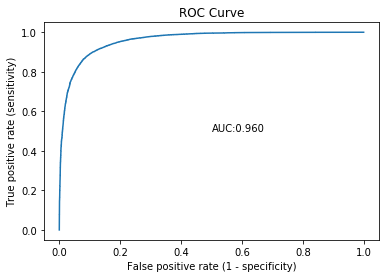

In [66]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_cnn = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_cnn))
plt.title('ROC Curve');

Our CNN model has a **ROC AUC** value of **0.960**. Let's store the accuracy and ROC AUC values for later.

In [73]:
model_scores['model'].append('Convolutional')
model_scores['accuracy'].append('{:.3f}'.format(acc_cnn))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_cnn))

model_scores

{'model': ['Dense', 'Convolutional'],
 'accuracy': ['0.846', '0.891'],
 'roc_auc': ['0.928', '0.960']}

Our **convolutional model achieved better results than our dense model**.

Let's see if we can improve these results even further with the help of **recurrent neural networks** - this is our **step 3**.

### Step 3

#### 1. Perform necessary imports

In [74]:
from keras.layers import SimpleRNN

#### 2. Load data

In [75]:
# considering the 10000 most frequent words

n_unique_words = 10000 #number of most frequent words to consider

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [76]:
max_review_length = 100 #maximum review length of 100 words
pad_type = 'pre' #add padding characters to the start of every review < 100 words
trunc_type = 'pre' #remove words from the beginning of every review > 100 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

We will change our neural network by **adding a SimpleRNN() layer** to our model, that as the name suggests is the simplest form of a recurrent layer.

We will also **change some of the hyperparameters** of the model to take into consideration the specificities of RNNs. We have also not included a dense layer after the recurrent layer since it usually does not provide a significant improvement in performance.

#### 4. Design a recurrent neural network (simple RNN layer)

In [77]:
# output directory name:
output_dir = 'text_classification_NN/rnn'

# training:
epochs = 16
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# simple RNN layer architecture:
n_rnn = 256 #number of neurons
drop_rnn = 0.2

model = Sequential(name='model_rnn')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(SimpleRNN(n_rnn, dropout=drop_rnn))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only have 2 classes

In [78]:
model.summary()

Model: "model_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 64)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               82176     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 722,433
Trainable params: 722,433
Non-trainable params: 0
_________________________________________________________________


Our RNN model is now ready to be compiled and trained.

#### 5. Compile model and create callback to save model parameters

In [79]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [81]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Train model

In [83]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/16
25000/25000 [==============================] - 34s 1ms/step - loss: 0.6727 - accuracy: 0.5616 - val_loss: 0.6206 - val_accuracy: 0.6394
Epoch 2/16
25000/25000 [==============================] - 39s 2ms/step - loss: 0.5930 - accuracy: 0.6746 - val_loss: 0.6186 - val_accuracy: 0.6362
Epoch 3/16
25000/25000 [==============================] - 36s 1ms/step - loss: 0.5379 - accuracy: 0.7196 - val_loss: 0.6177 - val_accuracy: 0.6466
Epoch 4/16
25000/25000 [==============================] - 33s 1ms/step - loss: 0.4434 - accuracy: 0.7933 - val_loss: 0.5768 - val_accuracy: 0.7242
Epoch 5/16
25000/25000 [==============================] - 36s 1ms/step - loss: 0.3507 - accuracy: 0.8490 - val_loss: 0.7473 - val_accuracy: 0.6079
Epoch 6/16
25000/25000 [==============================] - 37s 1ms/step - loss: 0.4806 - accuracy: 0.7636 - val_loss: 0.5220 - val_accuracy: 0.7752
Epoch 7/16
25000/25000 [==============================] - 38s 2ms/st

The **highest validation accuracy** is achieved in **epoch 10** and the **lowest validation loss** is achieved in **epoch 8**.

#### 7. Make predictions with the test set

In [82]:
# load parameters of epoch 8

output_dir = 'text_classification_NN/rnn'
model = load_model(output_dir+"/weights.08.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [83]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.11321864],
       [0.9625019 ],
       [0.04951205]], dtype=float32)

In [84]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [0]])

#### 8. Evaluate model

In [85]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[ 9802  2698]
 [ 2403 10097]]


In [86]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     12500
           1       0.79      0.81      0.80     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



In [87]:
# accuracy score

acc_rnn = accuracy_score(y_test, predictions_class)
print(acc_rnn)

0.79596


Our RNN model correctly classifies **79,6%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

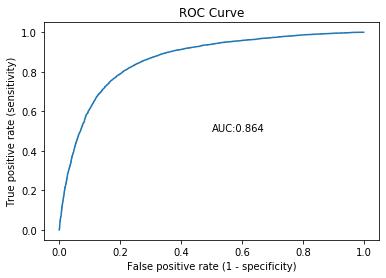

In [88]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_rnn = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_rnn))
plt.title('ROC Curve');

Our RNN model has a **ROC AUC** value of **0.864**. Let's store the accuracy and ROC AUC values for later.

In [89]:
model_scores['model'].append('RNN - simple RNN layer')
model_scores['accuracy'].append('{:.3f}'.format(acc_rnn))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_rnn))

model_scores

{'model': ['Dense', 'Convolutional', 'RNN - simple RNN layer'],
 'accuracy': ['0.846', '0.891', '0.796'],
 'roc_auc': ['0.928', '0.960', '0.864']}

Our **recurrent model did not perform so well - it had the worst result so far**. This may have happened because simple RNNs are only able to backpropagate through around 10 time steps before the gradient becomes so small that the parameter updates become almost negligible.

Let's see if we can counter this effect by using **more complex RNN architectures** like **Gated Recurrent Units (GRU)** and **Long Short-Term Memory (LSTM)** networks - these are our **steps 4 and 5**.

### Step 4

#### 1. Perform necessary imports

In [90]:
from keras.layers import GRU

We will use the same data we've used before, preprocessed in the same way.

#### 2. Design a recurrent neural network (GRU layer)

In [91]:
# output directory name:
output_dir = 'text_classification_NN/gru'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# GRU layer architecture:
n_gru = 256 #number of neurons
drop_gru = 0.2

model = Sequential(name='model_gru')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(GRU(n_gru, dropout=drop_gru))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [92]:
model.summary()

Model: "model_gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               246528    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 886,785
Trainable params: 886,785
Non-trainable params: 0
_________________________________________________________________


Our new RNN model with a GRU layer is now ready to be compiled and trained.

#### 3. Compile model and create callback to save model parameters

In [93]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [95]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 4. Train model

In [99]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 148s 6ms/step - loss: 0.5231 - accuracy: 0.7136 - val_loss: 0.4070 - val_accuracy: 0.8223
Epoch 2/4
25000/25000 [==============================] - 159s 6ms/step - loss: 0.3064 - accuracy: 0.8738 - val_loss: 0.4044 - val_accuracy: 0.8183
Epoch 3/4
25000/25000 [==============================] - 161s 6ms/step - loss: 0.2551 - accuracy: 0.8974 - val_loss: 0.3638 - val_accuracy: 0.8420
Epoch 4/4
25000/25000 [==============================] - 150s 6ms/step - loss: 0.2019 - accuracy: 0.9229 - val_loss: 0.3870 - val_accuracy: 0.8340


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 3**.

#### 5. Make predictions with the test set

In [96]:
# load parameters of epoch 3

output_dir = 'text_classification_NN/gru'
model = load_model(output_dir+"/weights.03.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [97]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.05291212],
       [0.95099264],
       [0.55228144]], dtype=float32)

In [98]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 6. Evaluate model

In [99]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10865  1635]
 [ 2314 10186]]


In [100]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85     12500
           1       0.86      0.81      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [101]:
# accuracy score

acc_gru = accuracy_score(y_test, predictions_class)
print(acc_gru)

0.84204


Our RNN model with a GRU layer correctly classifies **84,2%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

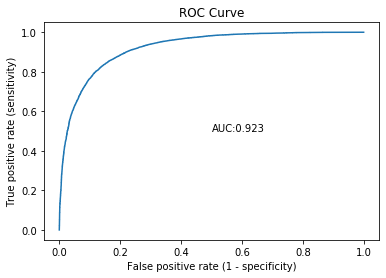

In [102]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_gru = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_gru))
plt.title('ROC Curve');

Our new model has a **ROC AUC** value of **0.923**. Let's store the accuracy and ROC AUC values for later.

In [103]:
model_scores['model'].append('RNN - GRU layer')
model_scores['accuracy'].append('{:.3f}'.format(acc_gru))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_gru))

model_scores

{'model': ['Dense',
  'Convolutional',
  'RNN - simple RNN layer',
  'RNN - GRU layer'],
 'accuracy': ['0.846', '0.891', '0.796', '0.842'],
 'roc_auc': ['0.928', '0.960', '0.864', '0.923']}

This is an improvement in comparison with our previous model, but it is still worse than our first two models. Let's see if we can improve this result using an **LSTM layer**.

### Step 5

#### 1. Perform necessary imports

In [104]:
from keras.layers import LSTM

#### 2. Design a recurrent neural network (LSTM layer)

In [105]:
# output directory name:
output_dir = 'text_classification_NN/lstm'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# LSTM layer architecture:
n_lstm = 256 #number of neurons
drop_lstm = 0.2

model = Sequential(name='model_lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(LSTM(n_lstm, dropout=drop_lstm))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [106]:
model.summary()

Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


Our new RNN model with an LSTM layer is now ready to be compiled and trained.

#### 3. Compile model and create callback to save model parameters

In [107]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [108]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [109]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 4. Train model

In [114]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 155s 6ms/step - loss: 0.4947 - accuracy: 0.7504 - val_loss: 0.3501 - val_accuracy: 0.8506
Epoch 2/4
25000/25000 [==============================] - 170s 7ms/step - loss: 0.2985 - accuracy: 0.8780 - val_loss: 0.3449 - val_accuracy: 0.8475
Epoch 3/4
25000/25000 [==============================] - 172s 7ms/step - loss: 0.2410 - accuracy: 0.9046 - val_loss: 0.3880 - val_accuracy: 0.8423
Epoch 4/4
25000/25000 [==============================] - 161s 6ms/step - loss: 0.1996 - accuracy: 0.9246 - val_loss: 0.3658 - val_accuracy: 0.8415


The **highest validation accuracy** is achieved in **epoch 1** and the **lowest validation loss** is achieved in **epoch 2**.

#### 5. Make predictions with the test set

In [110]:
# load parameters of epoch 2

output_dir = 'text_classification_NN/lstm'
model = load_model(output_dir+"/weights.02.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [111]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.24716255],
       [0.9733419 ],
       [0.7759752 ]], dtype=float32)

In [112]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 6. Evaluate model

In [113]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10195  2305]
 [ 1507 10993]]


In [114]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84     12500
           1       0.83      0.88      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



In [115]:
# accuracy score

acc_lstm = accuracy_score(y_test, predictions_class)
print(acc_lstm)

0.84752


Our RNN model with an LSTM layer correctly classifies **84,8%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

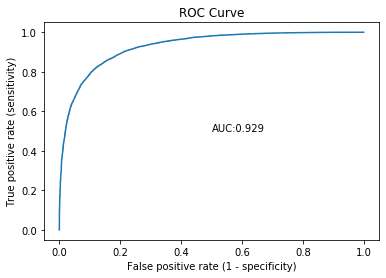

In [116]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_lstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_lstm))
plt.title('ROC Curve');

This model has a **ROC AUC** value of **0.929**. Let's store the accuracy and ROC AUC values for later.

In [117]:
model_scores['model'].append('RNN - LSTM layer')
model_scores['accuracy'].append('{:.3f}'.format(acc_lstm))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_lstm))

model_scores

{'model': ['Dense',
  'Convolutional',
  'RNN - simple RNN layer',
  'RNN - GRU layer',
  'RNN - LSTM layer'],
 'accuracy': ['0.846', '0.891', '0.796', '0.842', '0.848'],
 'roc_auc': ['0.928', '0.960', '0.864', '0.923', '0.929']}

This represents a slight improvement from the previous model, but is still lower than the ROC AUC value of our CNN model.

In **step 6** we will try to improve our results with the help of a **bidirectional LSTM**.

### Step 6

#### 1. Perform necessary imports

In [118]:
from keras.layers.wrappers import Bidirectional

#### 2. Load data

In [171]:
# considering the 10000 most frequent words

n_unique_words = 10000 #number of most frequent words to consider

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [172]:
max_review_length = 200 #maximum review length of 200 words
pad_type = 'pre' #add padding characters to the start of every review < 200 words
trunc_type = 'pre' #remove words from the beginning of every review > 200 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

#### 4. Design a recurrent neural network (bi-LSTM layer)

In [173]:
# output directory name:
output_dir = 'text_classification_NN/bi-lstm'

# training:
epochs = 6
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# bi-LSTM layer architecture:
n_lstm = 256 #number of neurons
drop_lstm = 0.2

model = Sequential(name='model_bi-lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [174]:
model.summary()

Model: "model_bi-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512)               657408    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 1,297,921
Trainable params: 1,297,921
Non-trainable params: 0
_________________________________________________________________


Our new RNN model with a bidirectional LSTM layer is now ready to be compiled and trained.

#### 5. Compile model and create callback to save model parameters

In [175]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [177]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Train model

In [130]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 908s 36ms/step - loss: 0.5455 - accuracy: 0.7174 - val_loss: 0.3824 - val_accuracy: 0.8360
Epoch 2/6
25000/25000 [==============================] - 1036s 41ms/step - loss: 0.3061 - accuracy: 0.8757 - val_loss: 0.3268 - val_accuracy: 0.8680
Epoch 3/6
25000/25000 [==============================] - 1110s 44ms/step - loss: 0.2311 - accuracy: 0.9121 - val_loss: 0.3336 - val_accuracy: 0.8648
Epoch 4/6
25000/25000 [==============================] - 1022s 41ms/step - loss: 0.1924 - accuracy: 0.9274 - val_loss: 0.3544 - val_accuracy: 0.8641
Epoch 5/6
25000/25000 [==============================] - 1070s 43ms/step - loss: 0.1525 - accuracy: 0.9451 - val_loss: 0.4024 - val_accuracy: 0.8573
Epoch 6/6
25000/25000 [==============================] - 1056s 42ms/step - loss: 0.1252 - accuracy: 0.9545 - val_loss: 0.4122 - val_accuracy: 0.8618


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 2**.

#### 7. Make predictions with the test set

In [178]:
# load parameters of epoch 2

output_dir = 'text_classification_NN/bi-lstm'
model = load_model(output_dir+"/weights.02.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [127]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.17112471],
       [0.96590513],
       [0.5913159 ]], dtype=float32)

In [128]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 8. Evaluate model

In [129]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[11025  1475]
 [ 1825 10675]]


In [130]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     12500
           1       0.88      0.85      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [131]:
# accuracy score

acc_bilstm = accuracy_score(y_test, predictions_class)
print(acc_bilstm)

0.868


Our RNN model with a bidirectional LSTM layer correctly classifies **86,8%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

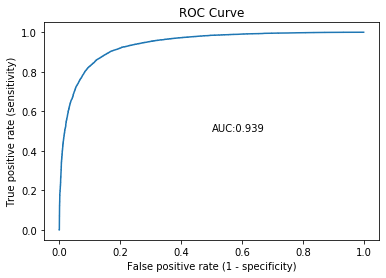

In [132]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_bilstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_bilstm))
plt.title('ROC Curve');

Our bi-LSTM model has a **ROC AUC** value of **0.939**. Let's store the accuracy and ROC AUC values for later.

In [133]:
model_scores['model'].append('RNN - bidirectional LSTM layer')
model_scores['accuracy'].append('{:.3f}'.format(acc_bilstm))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_bilstm))

model_scores

{'model': ['Dense',
  'Convolutional',
  'RNN - simple RNN layer',
  'RNN - GRU layer',
  'RNN - LSTM layer',
  'RNN - bidirectional LSTM layer'],
 'accuracy': ['0.846', '0.891', '0.796', '0.842', '0.848', '0.868'],
 'roc_auc': ['0.928', '0.960', '0.864', '0.923', '0.929', '0.939']}

This is our second best model so far, only surpassed in terms of performance by our CNN model.

We can try to **stack bi-LSTM layers** to improve our results - that's what we will do in **step 7**.

### Step 7

For this step, we will use exactly the same data we've used in step 6, preprocessed in the same way.

#### 1. Design a stacked recurrent neural network (2 bi-LSTM layers)

In [179]:
# output directory name:
output_dir = 'text_classification_NN/stacked_bi-lstm'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# stacked bi-LSTM layer architecture:
n_lstm_1 = 64 #number of neurons of LSTM layer 1
n_lstm_2 = 64 #number of neurons of LSTM layer 2
drop_lstm = 0.2
rec_drop_lstm = 0.2 #recurrent dropout

model = Sequential(name='model_stacked_bi-lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Bidirectional(LSTM(n_lstm_1, dropout=drop_lstm, recurrent_dropout=rec_drop_lstm, return_sequences=True)))
#with return_sequences=True this recurrent layer returns the hidden states for each step of the sequence

model.add(Bidirectional(LSTM(n_lstm_2, dropout=drop_lstm, recurrent_dropout=rec_drop_lstm)))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

Since both our **LSTM and bidirectional LSTM models seem to show a slight tendency to overfit**, we've also included a **recurrent dropout value of 0.2 in our 2 LSTM layers**, along with the regular dropout value.

In [180]:
model.summary()

Model: "model_stacked_bi-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 200, 64)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 128)          66048     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 804,993
Trainable params: 804,993
Non-trainable params: 0
_________________________________________________________________


Our stacked RNN model is now ready to be compiled and trained.

#### 2. Compile model and create callback to save model parameters

In [181]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [182]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [183]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 3. Train model

In [149]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 714s 29ms/step - loss: 0.4802 - accuracy: 0.7622 - val_loss: 0.3444 - val_accuracy: 0.8566
Epoch 2/4
25000/25000 [==============================] - 699s 28ms/step - loss: 0.3286 - accuracy: 0.8639 - val_loss: 0.3974 - val_accuracy: 0.8188
Epoch 3/4
25000/25000 [==============================] - 702s 28ms/step - loss: 0.2893 - accuracy: 0.8858 - val_loss: 0.3817 - val_accuracy: 0.8425
Epoch 4/4
25000/25000 [==============================] - 703s 28ms/step - loss: 0.2535 - accuracy: 0.9016 - val_loss: 0.3448 - val_accuracy: 0.8591


After the 4 epochs of training, the results are not conclusive. We've decided to extend the training for 4 more epochs, making a total of 8 epochs. If this was done right after the first 4 epochs of training, we just had to call `.fit()` again.

In order to do this after a break and not immediately after the first 4 epochs, we just need to use the Keras `load_model()` function like we've done before. 

In [21]:
output_dir = 'text_classification_NN/stacked_bi-lstm'
model = load_model(output_dir+"/weights.04.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=8, verbose=1, initial_epoch=4, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 5/8
25000/25000 [==============================] - 516s 21ms/step - loss: 0.2131 - accuracy: 0.9198 - val_loss: 0.3691 - val_accuracy: 0.8569
Epoch 6/8
25000/25000 [==============================] - 500s 20ms/step - loss: 0.1773 - accuracy: 0.9372 - val_loss: 0.3675 - val_accuracy: 0.8548
Epoch 7/8
25000/25000 [==============================] - 529s 21ms/step - loss: 0.1526 - accuracy: 0.9452 - val_loss: 0.3879 - val_accuracy: 0.8598
Epoch 8/8
25000/25000 [==============================] - 549s 22ms/step - loss: 0.1921 - accuracy: 0.9267 - val_loss: 0.3823 - val_accuracy: 0.8500


After the 8 epochs of training, the **highest validation accuracy** is achieved in **epoch 7** and the **lowest validation loss** is achieved in **epoch 1**.

Our model shows some signs of overfiting even after the introduction of recurrent dropout. We'll leave it like it is for now.

#### 4. Make predictions with the test set

In [184]:
# load parameters of epoch 1

output_dir = 'text_classification_NN/stacked_bi-lstm'
model = load_model(output_dir+"/weights.01.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [185]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.24861364],
       [0.9267259 ],
       [0.77547264]], dtype=float32)

In [186]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 5. Evaluate model

In [187]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[11008  1492]
 [ 2094 10406]]


In [188]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     12500
           1       0.87      0.83      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [189]:
# accuracy score

acc_stacked_bilstm = accuracy_score(y_test, predictions_class)
print(acc_stacked_bilstm)

0.85656


Our stacked RNN model with 2 bidirectional LSTMs layer correctly classifies **85,7%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

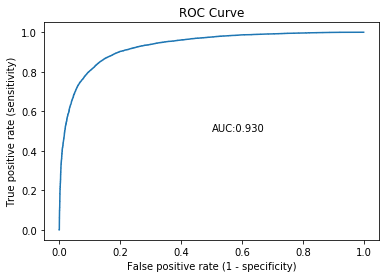

In [190]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_stacked_bilstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_stacked_bilstm))
plt.title('ROC Curve');

Our stacked RNN model has a **ROC AUC** value of **0.930**. Let's store the accuracy and ROC AUC values for later.

In [146]:
model_scores['model'].append('RNN - 2 bidirectional LSTM layers')
model_scores['accuracy'].append('{:.3f}'.format(acc_stacked_bilstm))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_stacked_bilstm))

model_scores

{'model': ['Dense',
  'Convolutional',
  'RNN - simple RNN layer',
  'RNN - GRU layer',
  'RNN - LSTM layer',
  'RNN - bidirectional LSTM layer',
  'RNN - 2 bidirectional LSTM layers'],
 'accuracy': ['0.846', '0.891', '0.796', '0.842', '0.848', '0.868', '0.857'],
 'roc_auc': ['0.928', '0.960', '0.864', '0.923', '0.929', '0.939', '0.930']}

This means we were not able to improve our previous result. We'll get back to this at a later stage.

In **step 8**, and since our best result so far was obtained by our convolutional model, we'll try a different approach: a **bidirectional LSTM layer stacked on top of a convolutional layer**.

### Step 8

#### 1. Perform necessary imports

In [191]:
from keras.layers import MaxPooling1D 

#### 2. Design a stacked (convolutional layer + bi-LSTM layer) neural network 

In [192]:
# output directory name:
output_dir = 'text_classification_NN/stacked_cnn_bi-lstm'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# convolutional layer architecture:
n_conv = 256 #number of filters/kernels
k_conv = 3 #kernel length

# bi-LSTM layer architecture:
n_lstm = 128 #number of neurons of LSTM layer
drop_lstm = 0.2

model = Sequential(name='model_stacked_cnn_bi-lstm')

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D())

model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))

model.add(Dense(1, activation='sigmoid')) #single output neuron; we use sigmoid because we only 

In [193]:
model.summary()

Model: "model_stacked_cnn_bi-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 200, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 198, 256)          49408     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 99, 256)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 1,083,905
Trainable params: 1,083,905
Non-trainable params: 0
_______________________________

Our new stacked model is now ready to be compiled and trained.

#### 3. Compile model and create callback to save model parameters

In [194]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [195]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [196]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 4. Train model

In [47]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 243s 10ms/step - loss: 0.4458 - accuracy: 0.7689 - val_loss: 0.3023 - val_accuracy: 0.8762
Epoch 2/4
25000/25000 [==============================] - 238s 10ms/step - loss: 0.2359 - accuracy: 0.9062 - val_loss: 0.2969 - val_accuracy: 0.8778
Epoch 3/4
25000/25000 [==============================] - 231s 9ms/step - loss: 0.1819 - accuracy: 0.9325 - val_loss: 0.3343 - val_accuracy: 0.8730
Epoch 4/4
25000/25000 [==============================] - 232s 9ms/step - loss: 0.1331 - accuracy: 0.9537 - val_loss: 0.3480 - val_accuracy: 0.8675


The **highest validation accuracy** and **lowest validation loss** is achieved in **epoch 2**.

#### 5. Make predictions with the test set

In [197]:
# load parameters of epoch 2

output_dir = 'text_classification_NN/stacked_cnn_bi-lstm'
model = load_model(output_dir+"/weights.02.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [198]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.08117866],
       [0.97127086],
       [0.9189605 ]], dtype=float32)

In [199]:
predictions_class = model.predict_classes(x_test)
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 6. Evaluate model

In [200]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[11154  1346]
 [ 1710 10790]]


In [201]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     12500
           1       0.89      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [202]:
# accuracy score

acc_stacked_cnn_bilstm = accuracy_score(y_test, predictions_class)
print(acc_stacked_cnn_bilstm)

0.87776


Our model with one bidirectional LSTM layer stacked on top of a convolutional layer correctly classifies **87,8%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

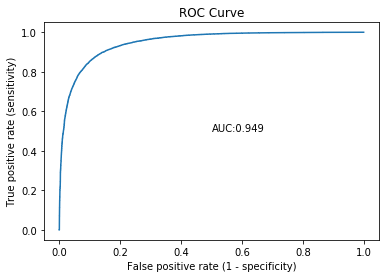

In [203]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_stacked_cnn_bilstm = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_stacked_cnn_bilstm))
plt.title('ROC Curve');

Our model has a **ROC AUC** value of **0.949**. Let's store the accuracy and ROC AUC values for later.

In [160]:
model_scores['model'].append('Convolutional layer + bidirectional LSTM layer')
model_scores['accuracy'].append('{:.3f}'.format(acc_stacked_cnn_bilstm))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_stacked_cnn_bilstm))

model_scores

{'model': ['Dense',
  'Convolutional',
  'RNN - simple RNN layer',
  'RNN - GRU layer',
  'RNN - LSTM layer',
  'RNN - bidirectional LSTM layer',
  'RNN - 2 bidirectional LSTM layers',
  'Convolutional layer + bidirectional LSTM layer'],
 'accuracy': ['0.846',
  '0.891',
  '0.796',
  '0.842',
  '0.848',
  '0.868',
  '0.857',
  '0.878'],
 'roc_auc': ['0.928',
  '0.960',
  '0.864',
  '0.923',
  '0.929',
  '0.939',
  '0.930',
  '0.949']}

This is an interesting result in terms of performance, but our CNN model is still the best one so far.

In a last effort to improve our results, we will take advantage of the Keras functional API and design a **non-sequential architecture** - this will be our **step 9**. 

### Step 9

#### 1. Perform necessary imports

In [204]:
from keras.models import Model
from keras.layers import Input, concatenate

#### 2. Load data

In [205]:
# considering the 5000 most frequent words as in our first step
# and removing the skip_top parameter

n_unique_words = 5000 #number of most frequent words to consider

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=n_unique_words)

#### 3. Preprocess data

In [206]:
max_review_length = 400 #maximum review length of 400 words
pad_type = 'pre' #add padding characters to the start of every review < 400 words
trunc_type = 'pre' #remove words from the beginning of every review > 400 words

x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

x_test = pad_sequences(x_test, maxlen=max_review_length,
                       padding=pad_type, truncating=trunc_type, value=0)

#### 4. Design a multi-convolutional neural network 

In [207]:
# output directory name:
output_dir = 'text_classification_NN/multi-conv'

# training:
epochs = 4
batch_size = 128

# vector-space embedding:
n_dim = 64 #number of dimensions of our word-vector space
drop_embed = 0.2

# convolutional layer architecture (3 parallel layers):
n_conv_1 = n_conv_2 = n_conv_3 = 256 #number of filters/kernels
k_conv_1 = 2 #kernel length
k_conv_2 = 3 #kernel length
k_conv_3 = 4 #kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

# input:
input_layer = Input(shape=(max_review_length, ), dtype='int16', name='input') 

# embedding: 
embedding_layer = Embedding(n_unique_words, n_dim, name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

# 3 parallel convolutional streams: 
conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

# concatenate the activations from the 3 streams: 
concat = concatenate([maxp_1, maxp_2, maxp_3])

# hidden dense layer
dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)

# sigmoid output layer: 
result = Dense(1, activation='sigmoid', name='output')(drop_dense_layer)

#### 5. Create model

In [208]:
model = Model(input_layer, result, name='model_multi-conv')

In [209]:
model.summary()

Model: "model_multi-conv"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 400)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 399, 256)     33024       drop_embed[0][0]                 
___________________________________________________________________________________

Our new model is now ready to be compiled and trained.

#### 6. Compile model and create callback to save model parameters

In [210]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [211]:
# callback to save model parameters after each epoch of training

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [212]:
# create folder if it does not exist

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 7. Train model

In [69]:
model.fit(x_train, y_train, 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[modelcheckpoint])

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 211s 8ms/step - loss: 0.4709 - accuracy: 0.7543 - val_loss: 0.2857 - val_accuracy: 0.8804
Epoch 2/4
25000/25000 [==============================] - 209s 8ms/step - loss: 0.2372 - accuracy: 0.9057 - val_loss: 0.2559 - val_accuracy: 0.8949
Epoch 3/4
25000/25000 [==============================] - 216s 9ms/step - loss: 0.1670 - accuracy: 0.9374 - val_loss: 0.2648 - val_accuracy: 0.8940
Epoch 4/4
25000/25000 [==============================] - 207s 8ms/step - loss: 0.1156 - accuracy: 0.9602 - val_loss: 0.2819 - val_accuracy: 0.8959


The **highest validation accuracy** is achieved in **epoch 4** and the **lowest validation loss** is achieved in **epoch 2**.

#### 8. Make predictions with the test set

In [213]:
# load parameters of epoch 2

output_dir = 'text_classification_NN/multi-conv'
model = load_model(output_dir+"/weights.02.hdf5")

C:\Users\joaon\Anaconda3\envs\DL-illustrated\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [214]:
predictions = model.predict(x_test)
predictions[0:3]

array([[0.02288392],
       [0.996283  ],
       [0.833138  ]], dtype=float32)

In [215]:
# since our model was defined using the functional API, there's no predict_classes attribute

predictions_class = np.rint(predictions).astype('int')
predictions_class[0:3]

array([[0],
       [1],
       [1]])

#### 9. Evaluate model

In [216]:
# confusion matrix

print(confusion_matrix(y_test, predictions_class))

[[10888  1612]
 [ 1015 11485]]


In [217]:
# classification report

print(classification_report(y_test, predictions_class))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     12500
           1       0.88      0.92      0.90     12500

    accuracy                           0.89     25000
   macro avg       0.90      0.89      0.89     25000
weighted avg       0.90      0.89      0.89     25000



In [218]:
# accuracy score

acc_multi_conv = accuracy_score(y_test, predictions_class)
print(acc_multi_conv)

0.89492


Our model with three parallel convolutional streams correctly classifies **89,5%** of our reviews as positive or negative. Let's plot the ROC curve and calculate the ROC AUC value of this model.

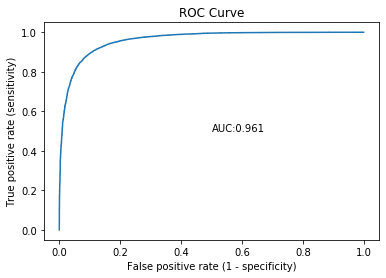

In [219]:
fpr, tpr, thresh = roc_curve(y_test, predictions)

area_uc_multi_conv = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel('False positive rate (1 - specificity)')
plt.ylabel('True positive rate (sensitivity)')
plt.text(0.5, 0.5, 'AUC:{:.3f}'.format(area_uc_multi_conv))
plt.title('ROC Curve');

Our model has a **ROC AUC** value of **0.961**. Let's store the accuracy and ROC AUC values for later.

In [220]:
model_scores['model'].append('Multi-convolutional')
model_scores['accuracy'].append('{:.3f}'.format(acc_multi_conv))
model_scores['roc_auc'].append('{:.3f}'.format(area_uc_multi_conv))

model_scores

{'model': ['Dense',
  'Convolutional',
  'RNN - simple RNN layer',
  'RNN - GRU layer',
  'RNN - LSTM layer',
  'RNN - bidirectional LSTM layer',
  'RNN - 2 bidirectional LSTM layers',
  'Convolutional layer + bidirectional LSTM layer',
  'Multi-convolutional'],
 'accuracy': ['0.846',
  '0.891',
  '0.796',
  '0.842',
  '0.848',
  '0.868',
  '0.857',
  '0.878',
  '0.895'],
 'roc_auc': ['0.928',
  '0.960',
  '0.864',
  '0.923',
  '0.929',
  '0.939',
  '0.930',
  '0.949',
  '0.961']}

This is our best result so far, even if only by a slight margin.

In **step 10** we'll briefly discuss these 9 models and **compare their performance**.

### Step 10

#### 1. Create dataframe with accuracy and ROC AUC values

In [221]:
df_models = pd.DataFrame(model_scores, columns = ['accuracy', 'roc_auc'], 
                         index = model_scores['model'])

df_models.columns = ['Accuracy', 'ROC AUC']

In [222]:
df_models

Accuracy ROC AUC
Dense                                             0.846   0.928
Convolutional                                     0.891   0.960
RNN - simple RNN layer                            0.796   0.864
RNN - GRU layer                                   0.842   0.923
RNN - LSTM layer                                  0.848   0.929
RNN - bidirectional LSTM layer                    0.868   0.939
RNN - 2 bidirectional LSTM layers                 0.857   0.930
Convolutional layer + bidirectional LSTM layer    0.878   0.949
Multi-convolutional                               0.895   0.961

Our **best result** is achieved by the **Multi-convolutional classifier**, both in terms of ROC AUC and accuracy, followed closely by our **Convolutional classifier**.

As for our **recurrent models**, they all show some signs of **overfitting**. With a **better hyperparameter tuning**, we might achieve better results. Nonetheless, the relatively small dataset that we've used may also not be best use case for this kind of models.

#### 2. Top 5 models

Ordering our models by their ROC AUC value, here's our **top 5**:

In [227]:
df_models.sort_values(by=['ROC AUC'], ascending=False).head()

Accuracy ROC AUC
Multi-convolutional                               0.895   0.961
Convolutional                                     0.891   0.960
Convolutional layer + bidirectional LSTM layer    0.878   0.949
RNN - bidirectional LSTM layer                    0.868   0.939
RNN - 2 bidirectional LSTM layers                 0.857   0.930